# Medical Image Classification

**Company Use Case:**

In healthcare, medical image classification is critical for accurate diagnosis but often involves handling sensitive patient data. Implementing homomorphic encryption (HE) in this context can revolutionize patient privacy and data security. By encrypting medical images, HE enables secure image processing in the cloud without revealing actual patient data. This process allows for advanced machine learning models to classify these images, assisting in diagnoses while maintaining complete data confidentiality.

**Approach:**

The following Notebook will show 2 approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by MedMNIST v2, a comprehensive collection of standardized biomedical images. It encompasses 12 datasets for 2D and 6 for 3D images, pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with corresponding classification labels. With 708,069 2D images and 9,998 3D images, it supports various classification tasks, from binary/multi-class to ordinal regression and multi-label, catering to biomedical image analysis, computer vision, and machine learning research and education.

https://medmnist.com/

**Dataset  1:**

_PneumoniaMNIST_

MedMNIST Description:

The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/pneumoniamnist.npz?download=1

**Dataset 2:**

_BreastMNIST_

MedMNIST Description:

The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.

https://zenodo.org/records/6496656/files/breastmnist.npz?download=1

**Dataset 3:**

_OrganCMNIST_

MedMNIST Description:

The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.

https://zenodo.org/records/6496656/files/organcmnist.npz?download=1

# FHE Mode

In [1]:
fhe_mode = 'execute'

# Imports

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# SciKit-Learn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

# PyTorch
import torch

# ConcreteML
import concrete.ml as cml
from concrete.ml.sklearn import NeuralNetClassifier
from concrete.ml.torch.compile import compile_brevitas_qat_model

# Skorch
from skorch.callbacks import EpochScoring

# Brevitas
import brevitas

In [3]:
# assert ConcreteML version 1.3.0
assert cml.__version__ == '1.3.0', 'ConcreteML version 1.3.0 required'
# # # print ConcreteML version
print(f'ConcreteML Version: {cml.__version__}')

ConcreteML Version: 1.3.0


In [4]:
# set random seed
np.random.seed(1)
torch.manual_seed(1)

# Plot Functions

In [5]:
################################################################################
# Plot Images
################################################################################

def plot_images(x_train, y_train, dataset):

    # plot sample images of each class
    n_classes = len(np.unique(y_train))

    if n_classes == 2:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax = ax.flatten()
        for i in range(n_classes):
            ax[i].imshow(x_train[y_train.flatten()==i][0][0], cmap='gray')
            ax[i].set_title(f'Class {i}')
            ax[i].axis('off')
    
    elif n_classes > 2:
        fig, ax = plt.subplots(nrows=3, ncols=n_classes//2, figsize=(10, 5))
        ax = ax.flatten()
        for i in range(n_classes):
            ax[i].imshow(x_train[y_train.flatten()==i][0][0], cmap='gray')
            ax[i].set_title(f'Class {i}')
            ax[i].axis('off')
        # remove empty subplots
        for i in range(n_classes, len(ax)):
            fig.delaxes(ax[i])

    fig.suptitle(dataset)
    plt.show()

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    if len(np.unique(y_true)) == 2:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred),2)
        recall = round(recall_score(y_true, y_pred),2)
        f1 = round(f1_score(y_true, y_pred),2)
        roc_auc = round(roc_auc_score(y_true, y_pred), 2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])
    else:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred, average='weighted'),2)
        recall = round(recall_score(y_true, y_pred, average='weighted'),2)
        f1 = round(f1_score(y_true, y_pred, average='weighted'),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])

    # barchart of metrics for each classifier
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [6]:
data_pneumonia = np.load('../Data/PneumoniaMNIST.npz')
xtrain_pneumonia, xval_pneumonia, xtest_pneumonia = data_pneumonia['xtrain'], data_pneumonia['xval'], data_pneumonia['xtest']
ytrain_pneumonia, yval_pneumonia, ytest_pneumonia = data_pneumonia['ytrain'], data_pneumonia['yval'], data_pneumonia['ytest']

In [7]:
data_breast = np.load('../Data/BreastMNIST.npz')
xtrain_breast, xval_breast, xtest_breast = data_breast['xtrain'], data_breast['xval'], data_breast['xtest']
ytrain_breast, yval_breast, ytest_breast = data_breast['ytrain'], data_breast['yval'], data_breast['ytest']

In [8]:
data_organ = np.load('../Data/OrganCMNIST.npz')
xtrain_organ, xval_organ, xtest_organ = data_organ['xtrain'], data_organ['xval'], data_organ['xtest']
ytrain_organ, yval_organ, ytest_organ = data_organ['ytrain'], data_organ['yval'], data_organ['ytest']

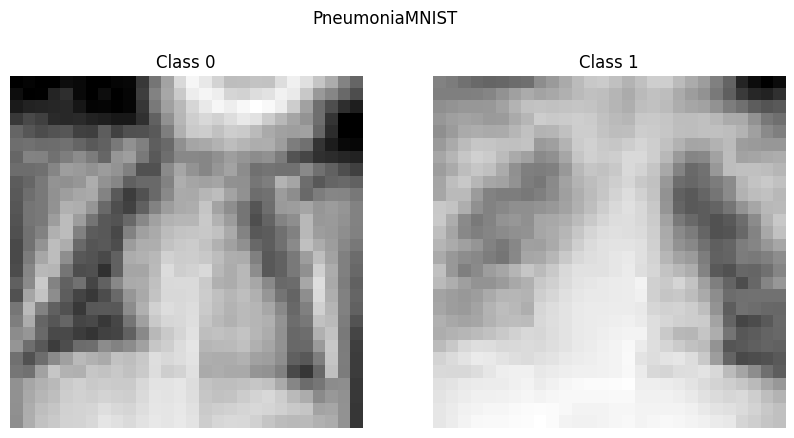

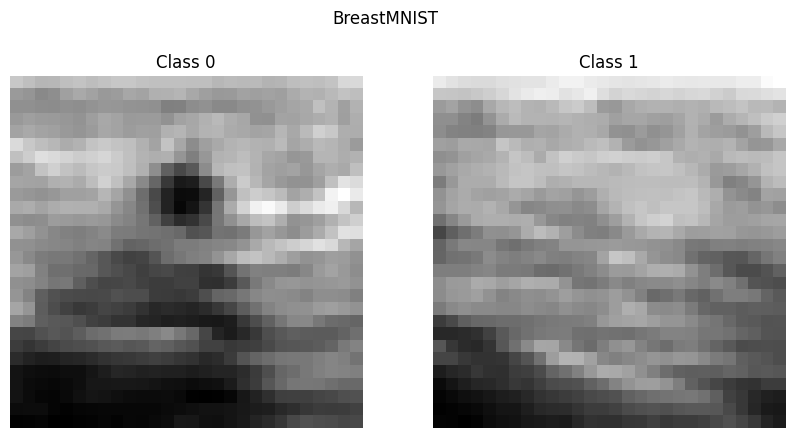

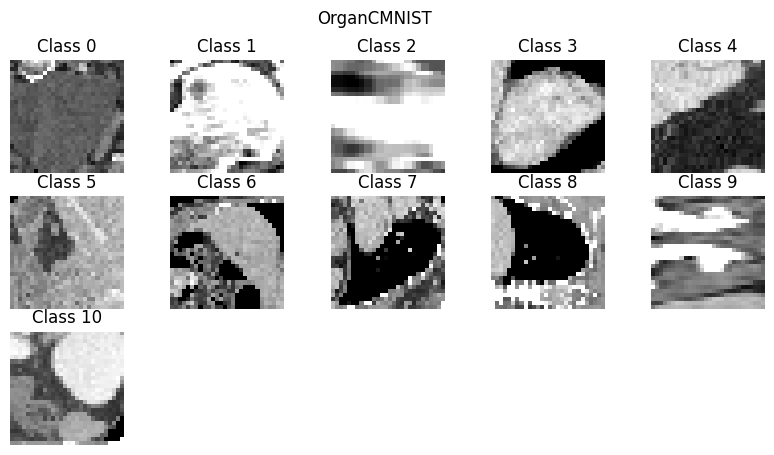

In [9]:
plot_images(xtrain_pneumonia, ytrain_pneumonia, dataset='PneumoniaMNIST')
plot_images(xtrain_breast, ytrain_breast, dataset='BreastMNIST')
plot_images(xtrain_organ, ytrain_organ, dataset='OrganCMNIST')

# Modelling

## Approach 1: Fully Connected Neural Network

### Scikit-Learn

In [10]:
class SklearnANN():

    def __init__(self, epochs=50, learning_rate=0.0001, weight_decay=0.0001, n_layers=2, neuron_factor=0.5):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_layers = n_layers
        self.neuron_factor = neuron_factor
        self.model = None
        self.log = {
            'train': 0,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None
        }

    def train(self, x_train, y_train, x_val, y_val, plot=True):
        # reshape data
        x_train, x_val = x_train.reshape(x_train.shape[0], -1), x_val.reshape(x_val.shape[0], -1)
        # initialize model
        self.model = MLPClassifier(
            hidden_layer_sizes=tuple([int(x_train.shape[1] * self.neuron_factor) for i in range(self.n_layers)]),
            learning_rate='adaptive',
            learning_rate_init=self.learning_rate,
            alpha=self.weight_decay,
            batch_size=128
        )
        # train model
        train_l, val_l, train_score, val_score = [], [], [], []
        for epoch in tqdm(range(self.epochs)):
            start_time = time.time()
            self.model.partial_fit(x_train, y_train, classes=np.unique(y_train))
            self.log['train'] += time.time() - start_time
            # curve metrics
            pred_train, pred_val = self.model.predict_proba(x_train), self.model.predict_proba(x_val)
            train_l.append(log_loss(y_train, pred_train, labels=np.unique(y_train)))
            val_l.append(log_loss(y_val, pred_val, labels=np.unique(y_val)))
            train_score.append(accuracy_score(y_train, np.argmax(pred_train, axis=1)))
            val_score.append(accuracy_score(y_val, np.argmax(pred_val, axis=1)))

        # plot results
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1].set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        return self

    def evaluate(self, X, y_true):
        # reshape data for sklearn
        X = X.reshape(X.shape[0], -1)
        # predict
        start_time = time.time()
        y_pred = self.model.predict(X)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate metrics
        if len(np.unique(y_true)) == 2:
            self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
            self.log['precision'] = round(precision_score(y_true, y_pred), 2)
            self.log['recall'] = round(recall_score(y_true, y_pred), 2)
            self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        else:
            self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
            self.log['precision'] = round(precision_score(y_true, y_pred, average='macro'), 2)
            self.log['recall'] = round(recall_score(y_true, y_pred, average='macro'), 2)
            self.log['f1'] = round(f1_score(y_true, y_pred, average='macro'), 2)
        # plot results
        plot_classification_metrics(y_true, y_pred, plot_title='Sklearn ANN')
        # return prediction labels
        return y_pred

#### PneumoniaMNIST

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


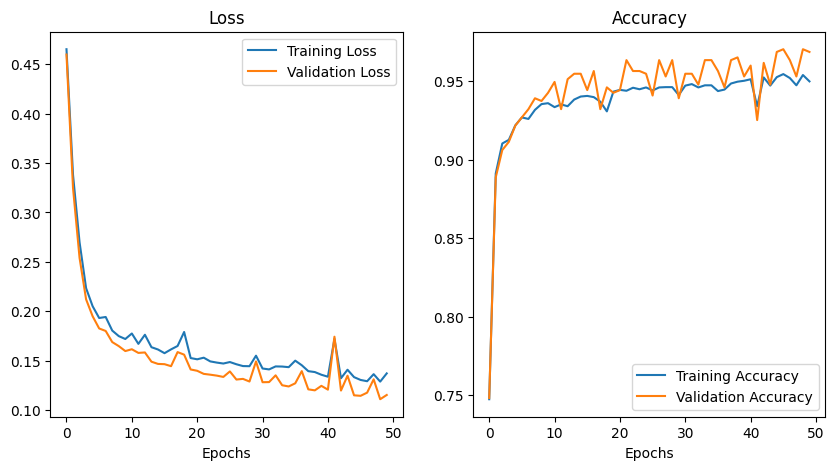

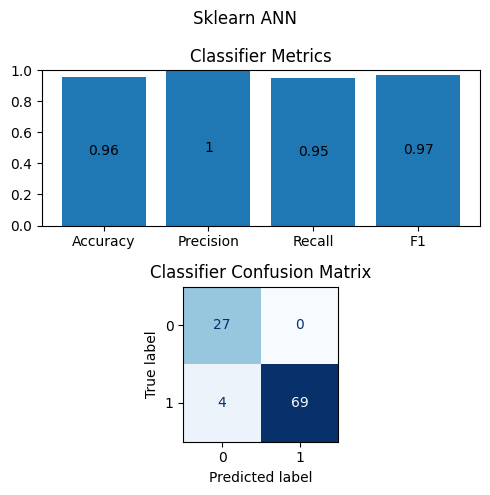

In [11]:
# initialize model
sklearn_ann = SklearnANN(
    epochs=50,
    learning_rate=0.0001,
    weight_decay=0.01,
    n_layers=2,
    neuron_factor=0.5
)
# train model
sklearn_ann = sklearn_ann.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    plot=True
)
# evaluate model
ypred_ann_sklearn = sklearn_ann.evaluate(xtest_pneumonia, ytest_pneumonia)

In [12]:
# display results
results = pd.DataFrame(sklearn_ann.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,65.752871,0.002314,0.000023,0.96,1.0,0.95,0.97


#### BreastMNIST

100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


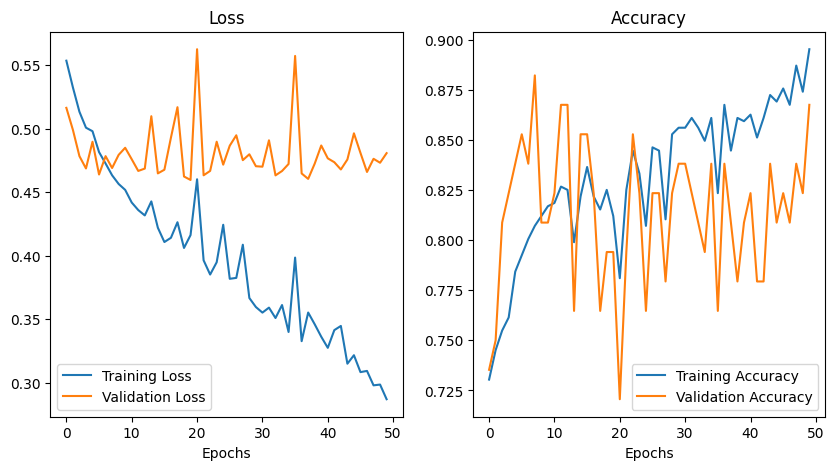

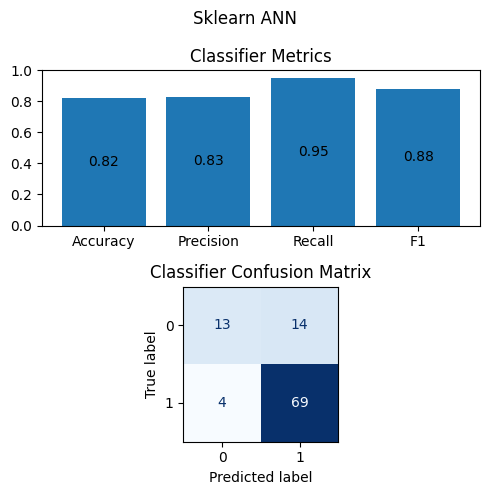

In [13]:
# initialize model
sklearn_ann = SklearnANN(
    epochs=50,
    learning_rate=0.0005,
    weight_decay=0.5,
    n_layers=2,
    neuron_factor=0.3,
)
# train model
sklearn_ann = sklearn_ann.train(
    x_train=xtrain_breast,
    y_train=ytrain_breast,
    x_val=xval_breast,
    y_val=yval_breast,
    plot=True
)
# evaluate model
ypred_ann_sklearn = sklearn_ann.evaluate(xtest_breast, ytest_breast)

In [14]:
# display results
results = pd.DataFrame(sklearn_ann.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,7.31202,0.001382,0.000014,0.82,0.83,0.95,0.88


#### OrganCMNIST

100%|██████████| 50/50 [02:14<00:00,  2.69s/it]


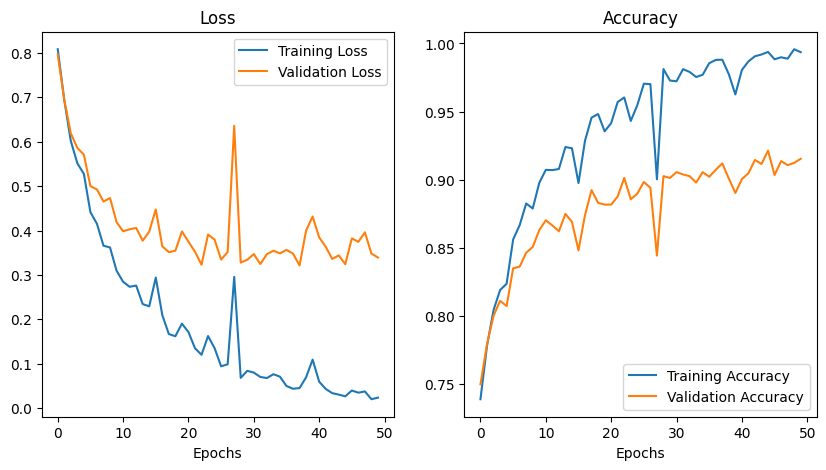

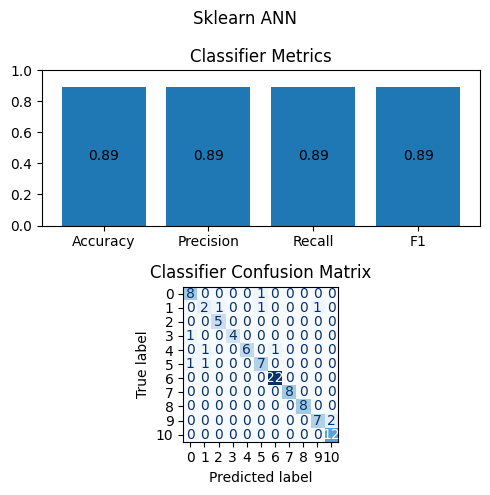

In [15]:
# initialize model
sklearn_ann = SklearnANN(
    epochs=50,
    learning_rate=0.0005,
    weight_decay=0.001,
    n_layers=2,
    neuron_factor=0.5
)
# train model
sklearn_ann = sklearn_ann.train(
    x_train=xtrain_organ,
    y_train=ytrain_organ,
    x_val=xval_organ,
    y_val=yval_organ,
    plot=True
)
# evaluate model
ypred_ann_sklearn = sklearn_ann.evaluate(xtest_organ, ytest_organ)

In [16]:
# display results
results = pd.DataFrame(sklearn_ann.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,124.483264,0.008162,0.000082,0.89,0.87,0.85,0.86


### Concrete

In [17]:
class ConcreteANN():
    
    def __init__(self, n_bits=2, epochs=50, learning_rate=0.0001, weight_decay=0.0001, n_layers=2, neuron_factor=0.5):
        self.n_bits = n_bits
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_layers = n_layers
        self.neuron_factor = neuron_factor
        self.model = None
        self.fhe_circuit = None
        self.log = {
            'n_bits': n_bits,
            'train': 0,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None
        }

    def train(self, x_train, y_train, x_val, y_val, plot=True):
        # combine and reshape data
        x_train = np.concatenate((x_train, x_val), axis=0)
        x_train = x_train.reshape(x_train.shape[0], -1)
        y_train = np.concatenate((y_train, y_val), axis=0).astype(np.int64)

        # initialize model
        self.model = NeuralNetClassifier(
            lr = self.learning_rate,
            max_epochs = self.epochs,
            batch_size = 128,
            callbacks = [EpochScoring(scoring='accuracy', name='train_acc', on_train=True)],
            verbose = 0,
            **{
                'module__n_layers': self.n_layers,
                'module__n_w_bits': self.n_bits,
                'module__n_a_bits': self.n_bits,
                'module__n_accum_bits': 16,
                'module__n_hidden_neurons_multiplier': self.neuron_factor,
                'optimizer__weight_decay': self.weight_decay,
            }
        )
        # train model
        start_time = time.time()
        self.model.fit(X=x_train, y=y_train)
        self.log['train'] = time.time() - start_time
        # compile model
        start_time = time.time()
        self.fhe_circuit = self.model.compile(x_train[:100])
        self.log['compile'] = time.time() - start_time

        # curve metrics
        train_l = self.model.sklearn_model.history[:, 'train_loss']
        val_l = self.model.sklearn_model.history[:, 'valid_loss']
        train_score = self.model.sklearn_model.history[:, 'train_acc']
        val_score = self.model.sklearn_model.history[:, 'valid_acc']
        # plot results
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        return self
    
    def evaluate(self, X, y_true, fhe='simulate'):
        # reshape data
        X = X.reshape(X.shape[0], -1)
        # key generation
        start_time = time.time()
        self.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # predict
        start_time = time.time()
        y_pred = np.array([self.model.predict(X[[i]], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))])
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # calculate metrics
        if len(np.unique(y_true)) == 2:
            self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
            self.log['precision'] = round(precision_score(y_true, y_pred), 2)
            self.log['recall'] = round(recall_score(y_true, y_pred), 2)
            self.log['f1'] = round(f1_score(y_true, y_pred), 2)
        else:
            self.log['accuracy'] = round(accuracy_score(y_true, y_pred), 2)
            self.log['precision'] = round(precision_score(y_true, y_pred, average='macro'), 2)
            self.log['recall'] = round(recall_score(y_true, y_pred, average='macro'), 2)
            self.log['f1'] = round(f1_score(y_true, y_pred, average='macro'), 2)
        # plot results
        plot_classification_metrics(y_true, y_pred, plot_title=f'Concrete ANN (n_bits={self.n_bits})')
        # return prediction labels
        return y_pred

#### PneumoniaMNIST

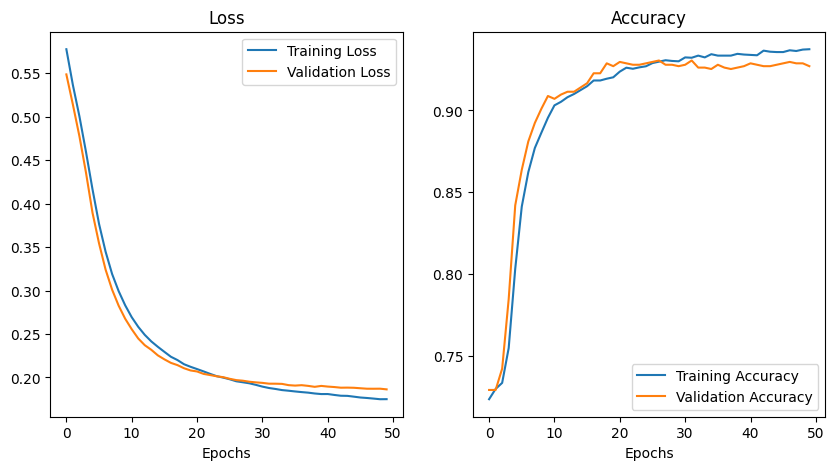

In [18]:
# fine-tune model

# initialize model
concrete_ann = ConcreteANN(
    n_bits=4,
    epochs=50,
    learning_rate=0.0001,
    weight_decay=0.01,
    n_layers=2,
    neuron_factor=0.5
)
# train model
concrete_ann = concrete_ann.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    plot=True
)

100%|██████████| 100/100 [06:46<00:00,  4.07s/it]


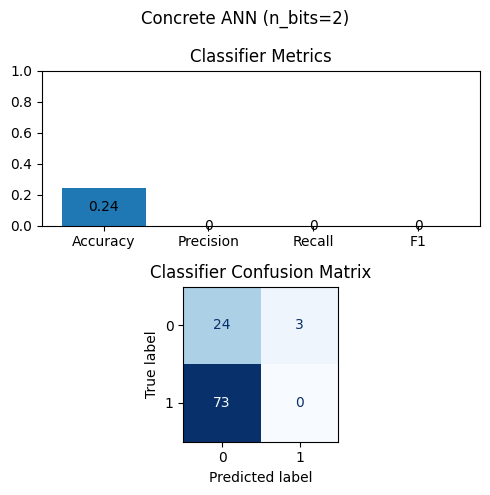

100%|██████████| 100/100 [09:32<00:00,  5.72s/it]


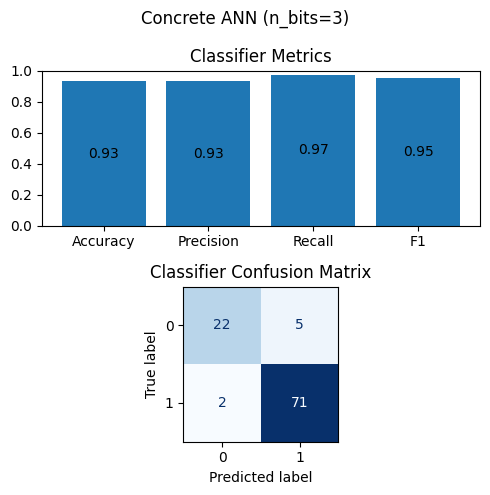

100%|██████████| 100/100 [12:02<00:00,  7.22s/it]


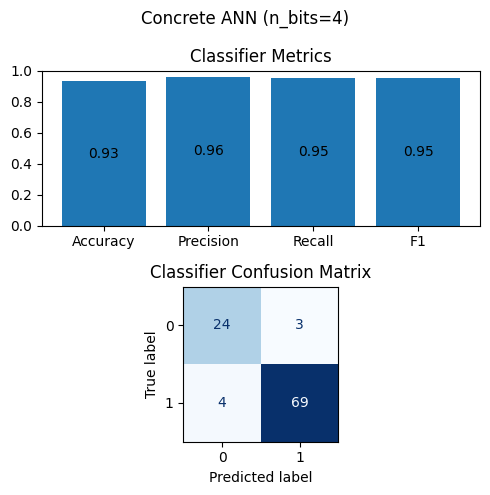

100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


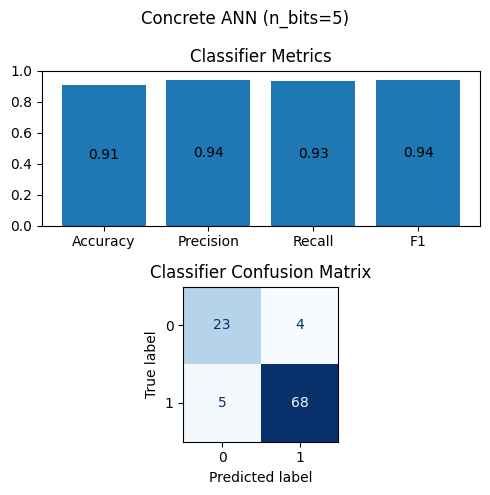

100%|██████████| 100/100 [12:41<00:00,  7.61s/it]


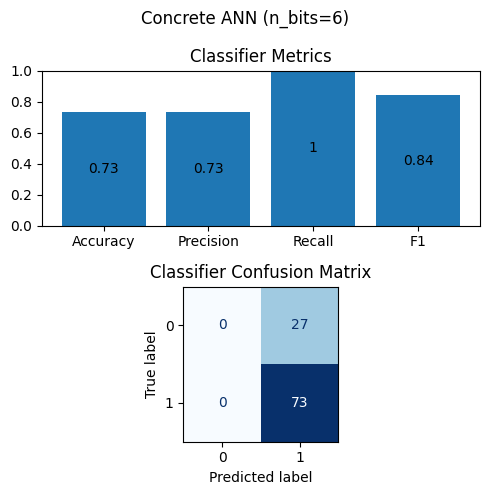

In [19]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_ann = ConcreteANN(
        n_bits=n_bits,
        epochs=50,
        learning_rate=0.0001,
        weight_decay=0.01,
        n_layers=2,
        neuron_factor=0.5
    )
    # train model
    concrete_ann = concrete_ann.train(
        x_train=xtrain_pneumonia,
        y_train=ytrain_pneumonia,
        x_val=xval_pneumonia,
        y_val=yval_pneumonia,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_ann.evaluate(xtest_pneumonia, ytest_pneumonia, fhe=fhe_mode)
    # append results
    results.append(concrete_ann.log)

In [20]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,25.508845,0.579605,1.662806,406.660020,4.066600,0.24,0.00,0.00,0.00
1,3,25.390930,0.547796,3.618986,572.423541,5.724235,0.93,0.93,0.97,0.95
2,4,26.770567,0.619589,3.746602,722.072903,7.220729,0.93,0.96,0.95,0.95
3,5,26.191110,0.570707,15.727477,528.156468,5.281565,0.91,0.94,0.93,0.94
4,6,26.877375,0.568649,241.227750,761.241664,7.612417,0.73,0.73,1.00,0.84


#### BreastMNIST

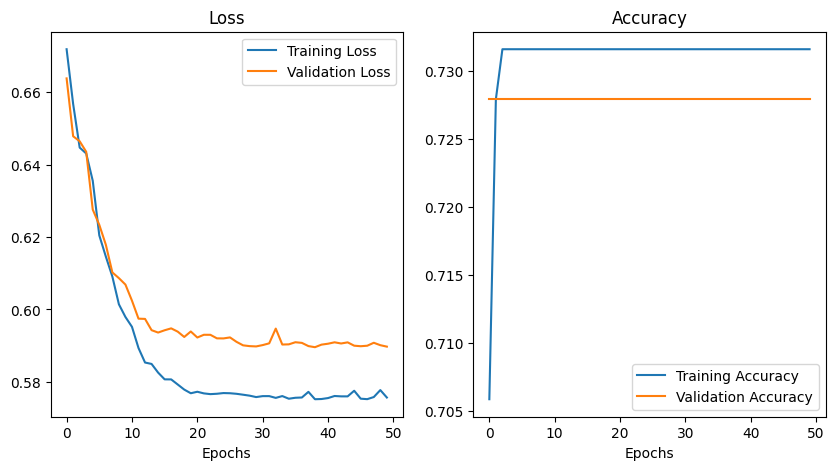

In [21]:
# fine-tune model

# initialize model
concrete_ann = ConcreteANN(
    n_bits=4,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=0.5,
    n_layers=2,
    neuron_factor=0.3
)
# train model
concrete_ann = concrete_ann.train(
    x_train=xtrain_breast,
    y_train=ytrain_breast,
    x_val=xval_breast,
    y_val=yval_breast,
    plot=True
)

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


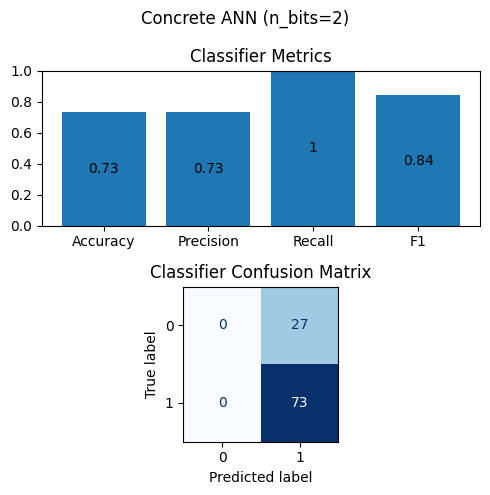

100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


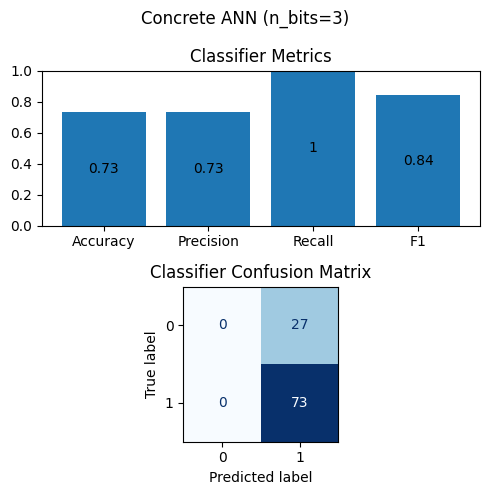

100%|██████████| 100/100 [07:25<00:00,  4.45s/it]


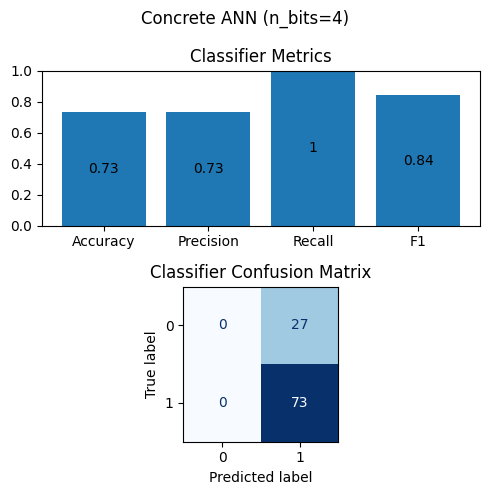

100%|██████████| 100/100 [06:29<00:00,  3.89s/it]


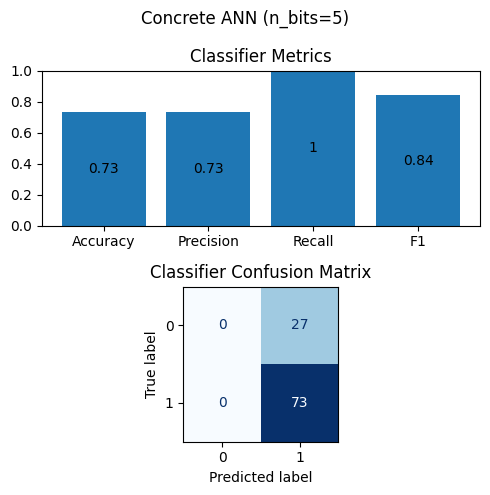

100%|██████████| 100/100 [16:41<00:00, 10.01s/it]


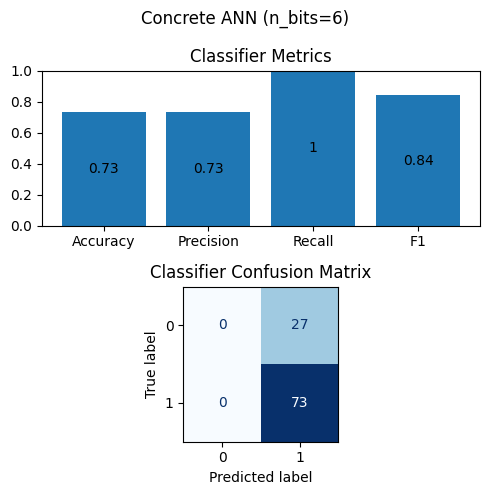

In [22]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_ann = ConcreteANN(
        n_bits=n_bits,
        epochs=50,
        learning_rate=0.0005,
        weight_decay=0.5,
        n_layers=2,
        neuron_factor=0.3
    )
    # train model
    concrete_ann = concrete_ann.train(
        x_train=xtrain_breast,
        y_train=ytrain_breast,
        x_val=xval_breast,
        y_val=yval_breast,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_ann.evaluate(xtest_breast, ytest_breast, fhe=fhe_mode)
    # append results
    results.append(concrete_ann.log)

In [23]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,4.520888,0.590551,2.266140,191.267462,1.912675,0.73,0.73,1.0,0.84
1,3,3.520469,0.612695,3.866381,271.373486,2.713735,0.73,0.73,1.0,0.84
2,4,3.947692,0.609666,12.268139,445.365746,4.453657,0.73,0.73,1.0,0.84
3,5,3.678245,0.624245,43.044341,389.196139,3.891961,0.73,0.73,1.0,0.84
4,6,3.765180,0.756697,1045.062929,1001.023324,10.010233,0.73,0.73,1.0,0.84


#### OrganCMNIST

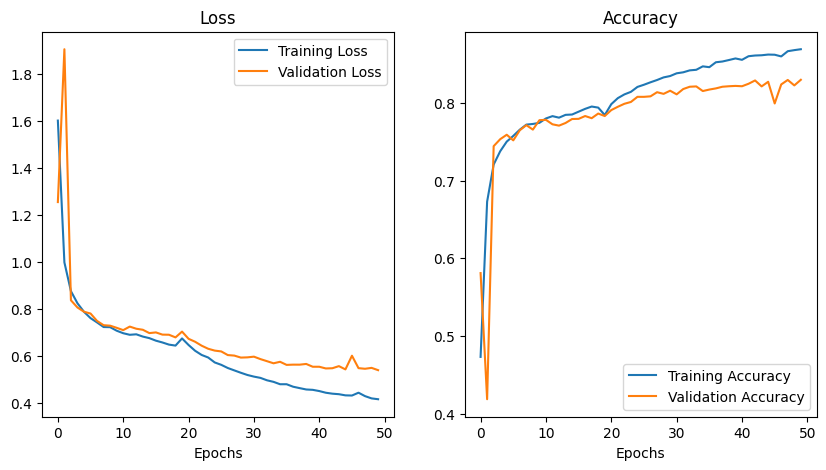

In [24]:
# fine-tune model

# initialize model
concrete_ann = ConcreteANN(
    n_bits=4,
    epochs=50,
    learning_rate=0.0005,
    weight_decay=0.001,
    n_layers=2,
    neuron_factor=0.5
)
# train model
concrete_ann = concrete_ann.train(
    x_train=xtrain_organ,
    y_train=ytrain_organ,
    x_val=xval_organ,
    y_val=yval_organ,
    plot=True
)

100%|██████████| 100/100 [06:59<00:00,  4.20s/it]


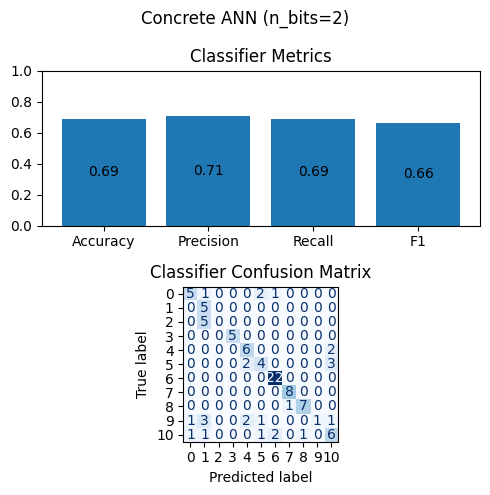

100%|██████████| 100/100 [14:10<00:00,  8.51s/it]


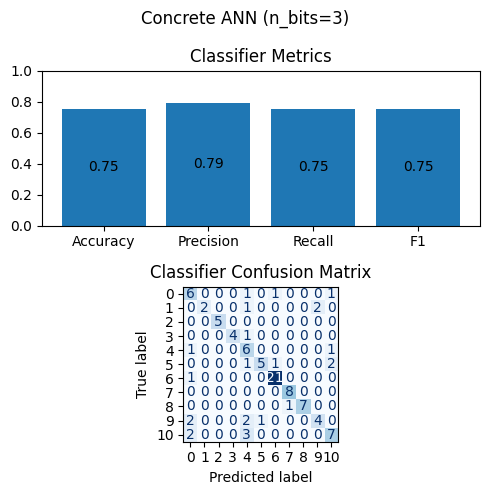

100%|██████████| 100/100 [19:38<00:00, 11.79s/it]


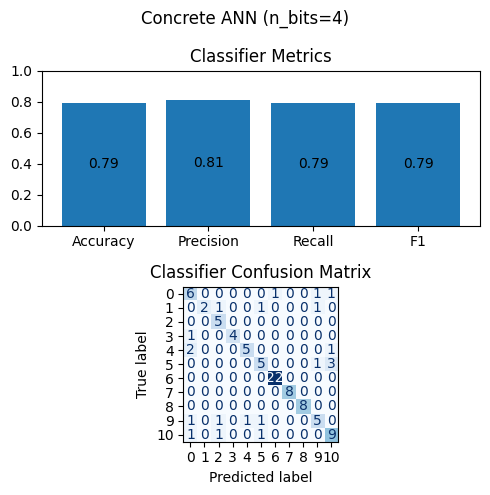

100%|██████████| 100/100 [29:01<00:00, 17.42s/it]


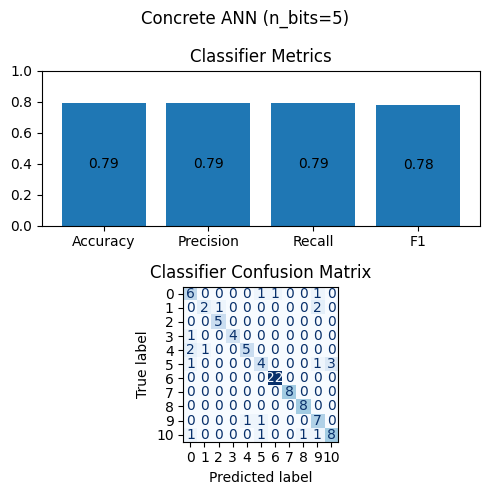

100%|██████████| 100/100 [28:17<00:00, 16.98s/it]


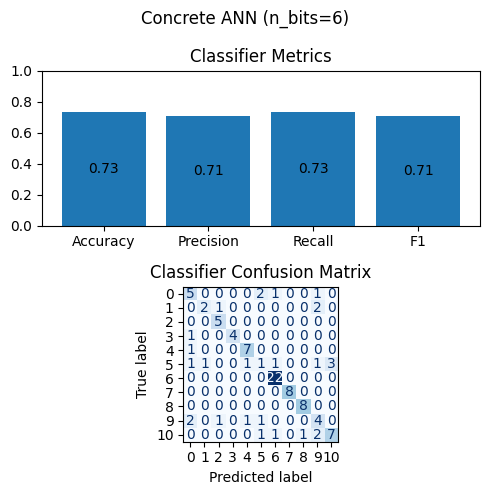

In [25]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_ann = ConcreteANN(
        n_bits=n_bits,
        epochs=50,
        learning_rate=0.0005,
        weight_decay=0.001,
        n_layers=2,
        neuron_factor=0.5
    )
    # train model
    concrete_ann = concrete_ann.train(
        x_train=xtrain_organ,
        y_train=ytrain_organ,
        x_val=xval_organ,
        y_val=yval_organ,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_ann.evaluate(xtest_organ, ytest_organ, fhe=fhe_mode)
    # append results
    results.append(concrete_ann.log)

In [26]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,108.674218,0.570727,3.939041,419.728908,4.197289,0.69,0.66,0.66,0.61
1,3,105.989249,0.662842,11.112603,850.778790,8.507788,0.75,0.80,0.73,0.74
2,4,116.755699,0.723377,10.896327,1178.533085,11.785331,0.79,0.80,0.76,0.76
3,5,116.803795,0.611264,60.085390,1741.821686,17.418217,0.79,0.78,0.76,0.76
4,6,121.708539,0.611852,245.202446,1697.790716,16.977907,0.73,0.70,0.71,0.70


## Approach 2: Convolutional Neural Network

### PyTorch

In [27]:
class TorchCNN():
    def __init__(self, epochs=30, learning_rate=0.0001, weight_decay=0.0001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.model = None
        self.log = {
            'train': 0,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None
        }

    def train(self, x_train, y_train, x_val, y_val, plot=True):
        # initialize model
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=432, out_features=len(np.unique(y_train)), bias=True)
        )
        # data to tensor
        x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long).flatten()
        x_val, y_val = torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.long).flatten()
        # criterion
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        # train loop
        train_l, val_l, train_score, val_score= [], [], [], []
        for epoch in tqdm(range(self.epochs)):
            # prune model and fine-tune for last 5 epochs
            if epoch == self.epochs - 5:
                for layer in self.model:
                    if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear)):
                        torch.nn.utils.prune.l1_unstructured(layer, name='weight', amount=0.3)

            # set model to train mode
            self.model.train()
            start_time = time.time()
            for i in range(0, len(x_train), 1):
                inputs, labels = x_train[i:i+1], y_train[i:i+1]
                # forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
            epoch_time = time.time() - start_time
            self.log['train'] += epoch_time

            # set model to eval mode
            self.model.eval()
            # calculate curve metrics
            with torch.no_grad():
                train_outputs = self.model(x_train)
                train_loss = criterion(train_outputs, y_train)
                predicted = torch.argmax(train_outputs, dim=1)
                train_accuracy = accuracy_score(predicted.detach().numpy(), y_train.detach().numpy())*100

                val_outputs = self.model(x_val)
                val_loss = criterion(val_outputs, y_val)
                predicted = torch.argmax(val_outputs, dim=1)
                val_accuracy = accuracy_score(predicted.detach().numpy(), y_val.detach().numpy())*100

            train_l.append(train_loss.item())
            val_l.append(val_loss.item())
            train_score.append(train_accuracy)
            val_score.append(val_accuracy)

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        # make pruning permanent
        for layer in self.model:
            if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear)):
                torch.nn.utils.prune.remove(layer, 'weight')

        return self

    def evaluate(self, X, y_true):
        # data to tensor
        X = torch.tensor(X, dtype=torch.float)
        # set model to eval mode
        self.model.eval()
        # predict
        start_time = time.time()
        with torch.no_grad():
            # predict each sample individually
            outputs = [self.model(X[[i]]) for i in tqdm(range(X.shape[0]))]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # get binary predictions
        y_pred = torch.argmax(torch.cat(outputs), dim=1).detach().numpy().flatten()
        # calculate metrics
        if len(np.unique(y_pred)) == 2:
            self.log['accuracy'] = accuracy_score(y_true, y_pred)
            self.log['precision'] = precision_score(y_true, y_pred)
            self.log['recall'] = recall_score(y_true, y_pred)
            self.log['f1'] = f1_score(y_true, y_pred)
        else:
            self.log['accuracy'] = accuracy_score(y_true, y_pred)
            self.log['precision'] = precision_score(y_true, y_pred, average='macro')
            self.log['recall'] = recall_score(y_true, y_pred, average='macro')
            self.log['f1'] = f1_score(y_true, y_pred, average='macro')
        # plot results
        plot_classification_metrics(y_true, y_pred, plot_title='Torch CNN')
        # return prediction labels
        return y_pred

#### PneumoniaMNIST

100%|██████████| 30/30 [02:14<00:00,  4.50s/it]


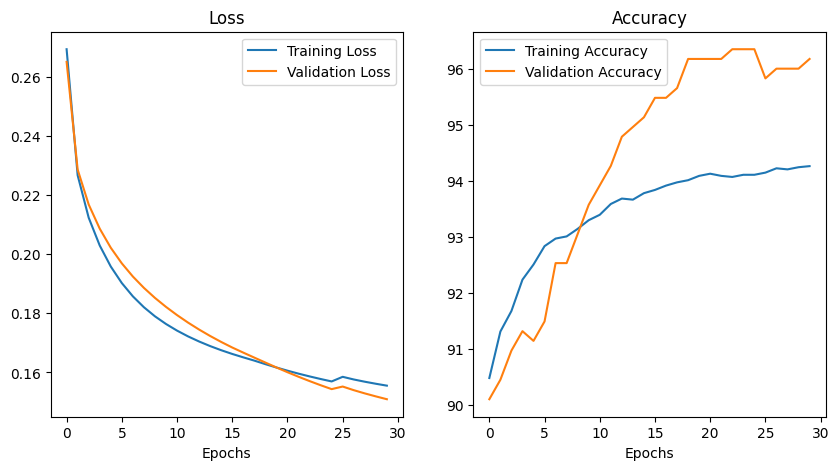

100%|██████████| 100/100 [00:00<00:00, 4556.85it/s]


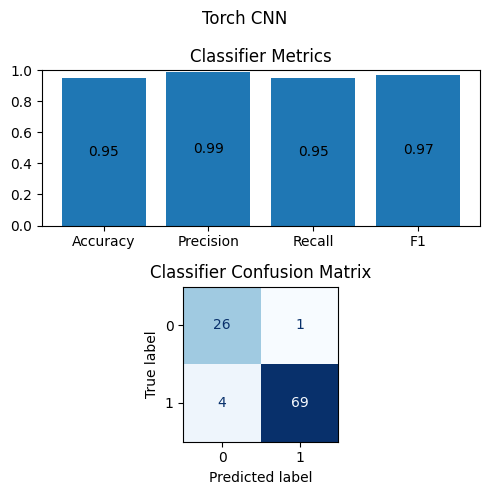

In [28]:
# initialize model
torch_cnn = TorchCNN(
    epochs=30,
    learning_rate=0.0001,
    weight_decay=0.0001
)
# train model
torch_cnn = torch_cnn.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    plot=True
)
# evaluate model
ypred_torch = torch_cnn.evaluate(xtest_pneumonia, ytest_pneumonia)

In [29]:
# display results
results = pd.DataFrame(torch_cnn.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,133.250565,0.024204,0.000242,0.95,0.985714,0.945205,0.965035


#### BreastMNIST

100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


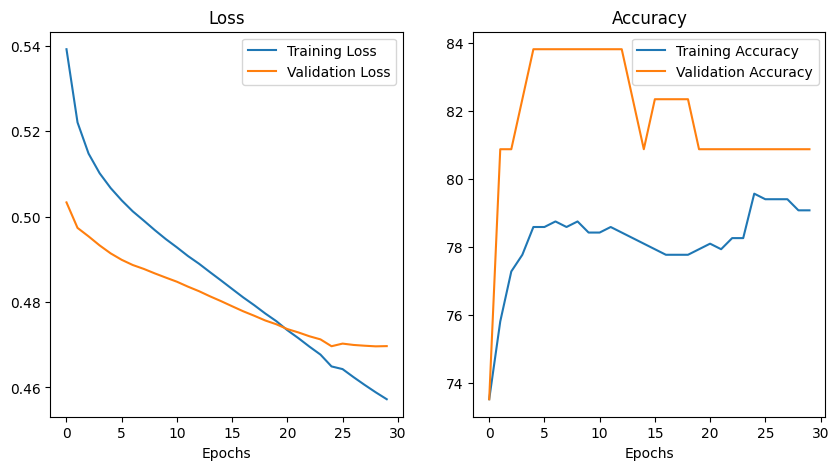

100%|██████████| 100/100 [00:00<00:00, 6059.73it/s]


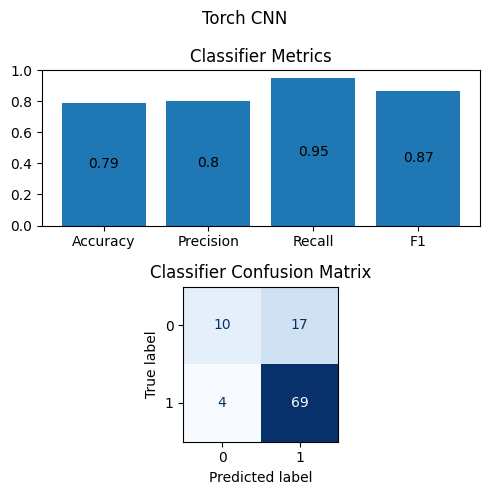

In [30]:
# initialize model
torch_cnn = TorchCNN(
    epochs=30,
    learning_rate=0.001,
    weight_decay=0.01
)
# train model
torch_cnn = torch_cnn.train(
    x_train=xtrain_breast,
    y_train=ytrain_breast,
    x_val=xval_breast,
    y_val=yval_breast,
    plot=True
)
# evaluate model
ypred_torch = torch_cnn.evaluate(xtest_breast, ytest_breast)

In [31]:
# display results
results = pd.DataFrame(torch_cnn.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,17.144237,0.018718,0.000187,0.79,0.802326,0.945205,0.867925


#### OrganCMNIST

100%|██████████| 30/30 [09:26<00:00, 18.87s/it]


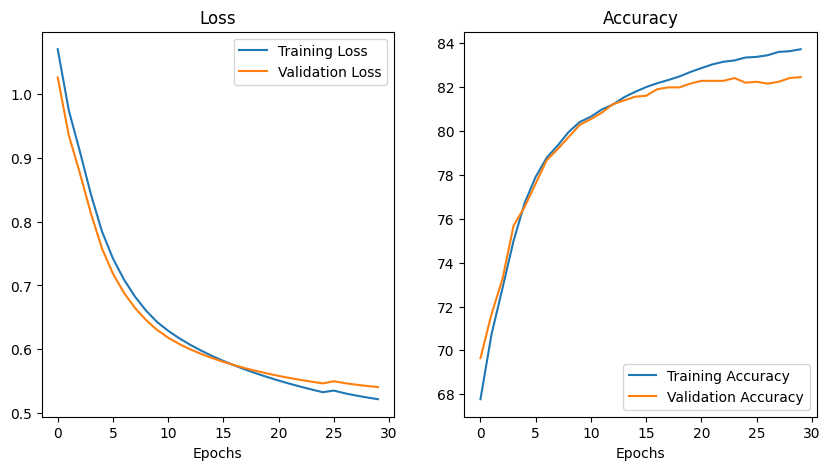

100%|██████████| 100/100 [00:00<00:00, 8201.93it/s]


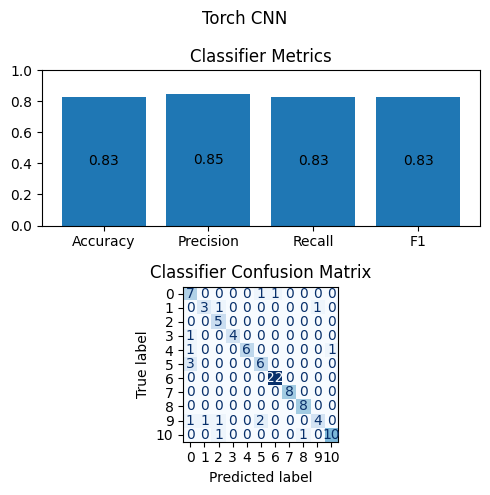

In [32]:
# initialize model
torch_cnn = TorchCNN(
    epochs=30,
    learning_rate=0.0001,
    weight_decay=0.001
)
# train model
torch_cnn = torch_cnn.train(
    x_train=xtrain_organ,
    y_train=ytrain_organ,
    x_val=xval_organ,
    y_val=yval_organ,
    plot=True
)
# evaluate model
ypred_torch = torch_cnn.evaluate(xtest_organ, ytest_organ)

In [33]:
# display results
results = pd.DataFrame(torch_cnn.log, index=[0])
results

,train,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,560.262051,0.014789,0.000148,0.83,0.830421,0.806566,0.804083


### Concrete

In [34]:
class ConcreteCNN():
    def __init__(self, n_bits=2, epochs=30, learning_rate=0.0001, weight_decay=0.0001):
        self.n_bits = n_bits
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.brevitas_model = None
        self.concrete_model = None
        self.log = {
            'n_bits': n_bits,
            'train': 0,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None,
            'accuracy': None,
            'precision': None,
            'recall': None,
            'f1': None
        }

    def train(self, x_train, y_train, x_val, y_val, plot=True):
        # initialize model
        self.brevitas_model = torch.nn.Sequential(
            # entry point of a network has to be a QuantIdentity layer
            # to quantize the inputs
            brevitas.nn.QuantIdentity(bit_width=self.n_bits, return_quant_tensor=True),
            # brevitas QuantConv2d layer
            brevitas.nn.QuantConv2d(in_channels=1, out_channels=3, kernel_size=5, weight_bit_width=self.n_bits),
            # brevitas QuantReLU layer
            brevitas.nn.QuantReLU(bit_width=self.n_bits),
            # torch AvgPool2d layer
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            # after a PyTorch layer there needs to follow a QuantIdentity layer
            # to make sure the inputs are quantized correctly
            brevitas.nn.QuantIdentity(bit_width=self.n_bits, return_quant_tensor=True),
            # PyTorch flatten layer
            torch.nn.Flatten(),
            # again a QuantIdentity layer after the PyTorch layer
            brevitas.nn.QuantIdentity(bit_width=self.n_bits, return_quant_tensor=True),
            # brevitas QuantLinear (output) layer
            brevitas.nn.QuantLinear(in_features=432, out_features=len(np.unique(y_train)), bias=True, weight_bit_width=self.n_bits)
        )
        # data to tensor
        x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long).flatten()
        x_val, y_val = torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.long).flatten()
        # criterion
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer
        optimizer = torch.optim.Adam(self.brevitas_model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        # train loop
        train_l, val_l, train_score, val_score= [], [], [], []
        for epoch in tqdm(range(self.epochs)):
            # prune model and fine-tune for last 5 epochs
            if epoch == self.epochs - 5:
                for layer in self.brevitas_model:
                    if isinstance(layer, (brevitas.nn.QuantConv2d, brevitas.nn.QuantLinear)):
                        torch.nn.utils.prune.l1_unstructured(layer, name='weight', amount=0.3)
            
            # set model to train mode
            self.brevitas_model.train()
            start_time = time.time()
            for i in range(0, len(x_train), 1):
                inputs, labels = x_train[i:i+1], y_train[i:i+1]
                # forward pass
                outputs = self.brevitas_model(inputs)
                loss = criterion(outputs, labels)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
            epoch_time = time.time() - start_time
            self.log['train'] += epoch_time

            # set model to eval mode
            self.brevitas_model.eval()
            # calculate curve metrics
            with torch.no_grad():
                train_outputs = self.brevitas_model(x_train)
                train_loss = criterion(train_outputs, y_train)
                predicted = torch.argmax(train_outputs, dim=1)
                train_accuracy = accuracy_score(predicted.detach().numpy(), y_train.detach().numpy())*100

                val_outputs = self.brevitas_model(x_val)
                val_loss = criterion(val_outputs, y_val)
                predicted = torch.argmax(val_outputs, dim=1)
                val_accuracy = accuracy_score(predicted.detach().numpy(), y_val.detach().numpy())*100

            train_l.append(train_loss.item())
            val_l.append(val_loss.item())
            train_score.append(train_accuracy)
            val_score.append(val_accuracy)

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        # make pruning permanent
        for layer in self.brevitas_model:
            if isinstance(layer, (brevitas.nn.QuantConv2d, brevitas.nn.QuantLinear)):
                torch.nn.utils.prune.remove(layer, 'weight')

        # compile model
        start_time = time.time()
        self.concrete_model = compile_brevitas_qat_model(self.brevitas_model, x_train[:100], rounding_threshold_bits=6)
        self.log['compile'] = time.time() - start_time

        bit_width = self.concrete_model.fhe_circuit.graph.maximum_integer_bit_width()
        print(f'WARNING: Maximum bit-width of 16 exceeded ({bit_width})') if bit_width > 16 else None

        return self
    
    def evaluate(self, X, y_true, fhe='simulate'):
        # keygen
        start_time = time.time()
        self.concrete_model.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # predict
        start_time = time.time()
        with torch.no_grad():
            # predict each sample individually
            outputs = [self.concrete_model.forward(X[[i]], fhe=fhe) for i in tqdm(range(X.shape[0]))]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # get binary predictions from numpy outputs
        y_pred = np.argmax(np.concatenate(outputs), axis=1)
        # calculate metrics
        if len(np.unique(y_pred)) == 2:
            self.log['accuracy'] = accuracy_score(y_true, y_pred)
            self.log['precision'] = precision_score(y_true, y_pred)
            self.log['recall'] = recall_score(y_true, y_pred)
            self.log['f1'] = f1_score(y_true, y_pred)
        else:
            self.log['accuracy'] = accuracy_score(y_true, y_pred)
            self.log['precision'] = precision_score(y_true, y_pred, average='macro')
            self.log['recall'] = recall_score(y_true, y_pred, average='macro')
            self.log['f1'] = f1_score(y_true, y_pred, average='macro')
        # plot results
        plot_classification_metrics(y_true, y_pred, plot_title=f'Concrete CNN (n_bits={self.n_bits})')
        # return prediction labels
        return y_pred

#### PneumoniaMNIST

100%|██████████| 30/30 [10:43<00:00, 21.44s/it]


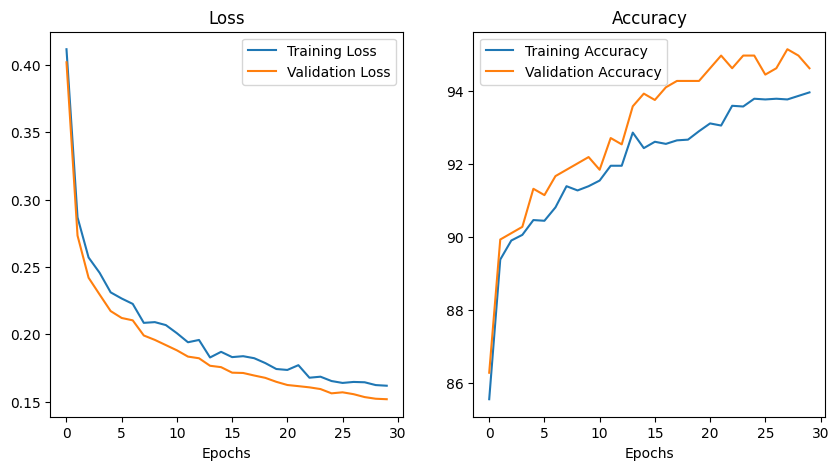

In [35]:
# fine-tune model

# initialize model
concrete_cnn = ConcreteCNN(
    n_bits=4,
    epochs=30,
    learning_rate=0.0001,
    weight_decay=0.0001
)
# train model
concrete_cnn = concrete_cnn.train(
        x_train=xtrain_pneumonia,
        y_train=ytrain_pneumonia,
        x_val=xval_pneumonia,
        y_val=yval_pneumonia,
        plot=True
)

100%|██████████| 100/100 [25:08<00:00, 15.09s/it]


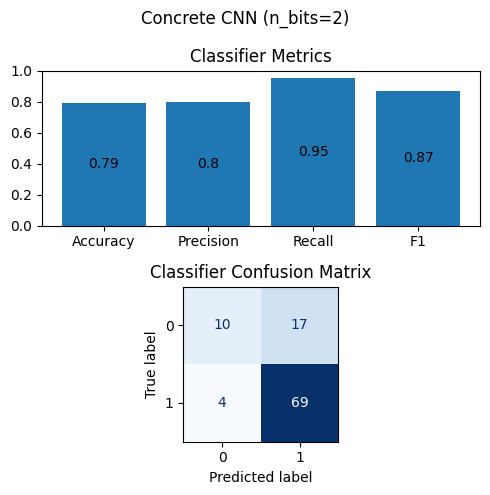

100%|██████████| 100/100 [1:34:58<00:00, 56.98s/it]


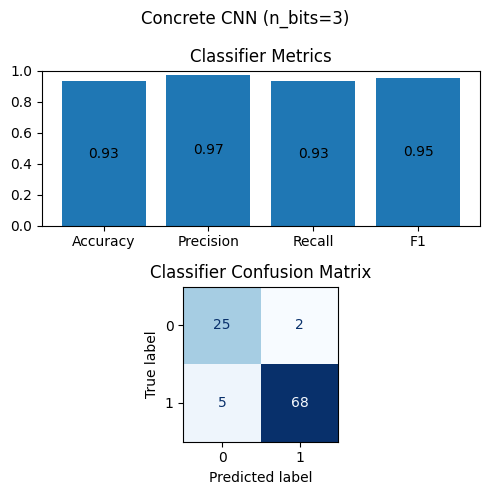

100%|██████████| 100/100 [1:35:48<00:00, 57.49s/it]


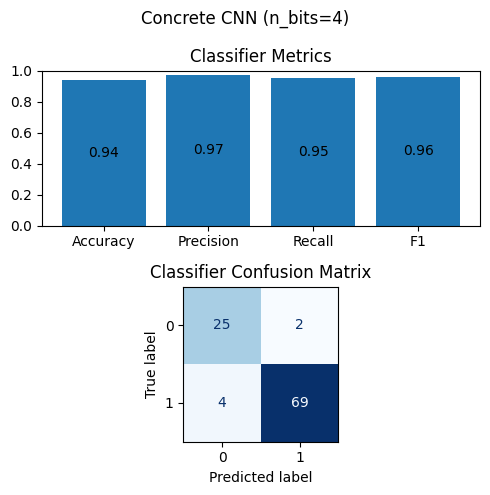

100%|██████████| 100/100 [3:20:08<00:00, 120.09s/it] 


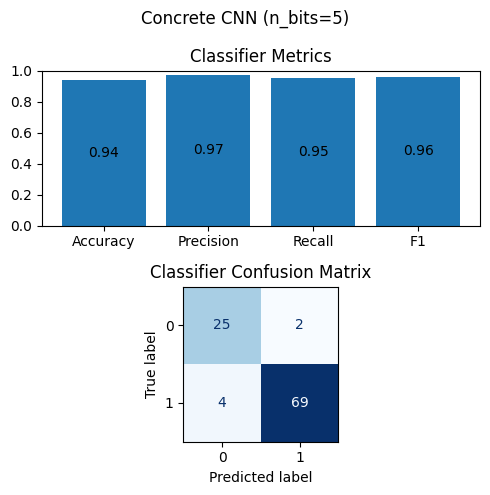

100%|██████████| 100/100 [4:08:55<00:00, 149.35s/it] 


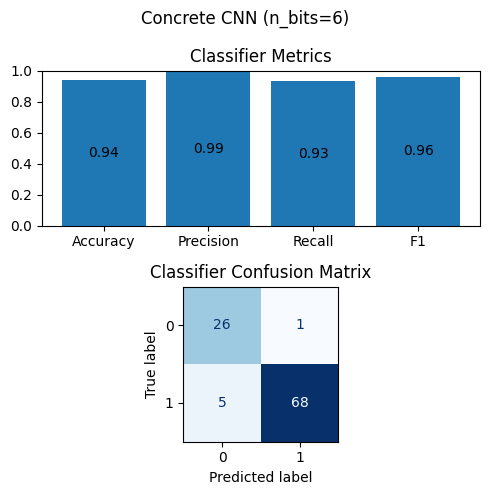

In [36]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_cnn = ConcreteCNN(
        n_bits=n_bits,
        epochs=30,
        learning_rate=0.0001,
        weight_decay=0.0001
    )
    # train model
    concrete_cnn = concrete_cnn.train(
        x_train=xtrain_pneumonia,
        y_train=ytrain_pneumonia,
        x_val=xval_pneumonia,
        y_val=yval_pneumonia,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_cnn.evaluate(xtest_pneumonia, ytest_pneumonia, fhe=fhe_mode)
    # append results
    results.append(concrete_cnn.log)

In [37]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,650.644893,1.191204,8.275803,1508.974713,15.089747,0.79,0.802326,0.945205,0.867925
1,3,655.366985,1.702464,29.553150,5698.216935,56.982169,0.93,0.971429,0.931507,0.951049
2,4,657.175506,1.411336,26.198214,5748.633157,57.486332,0.94,0.971831,0.945205,0.958333
3,5,675.504624,1.277641,26.837165,12008.832067,120.088321,0.94,0.971831,0.945205,0.958333
4,6,706.288573,1.210872,64.876277,14935.036076,149.350361,0.94,0.985507,0.931507,0.957746


#### BreastMNIST

100%|██████████| 30/30 [01:26<00:00,  2.89s/it]


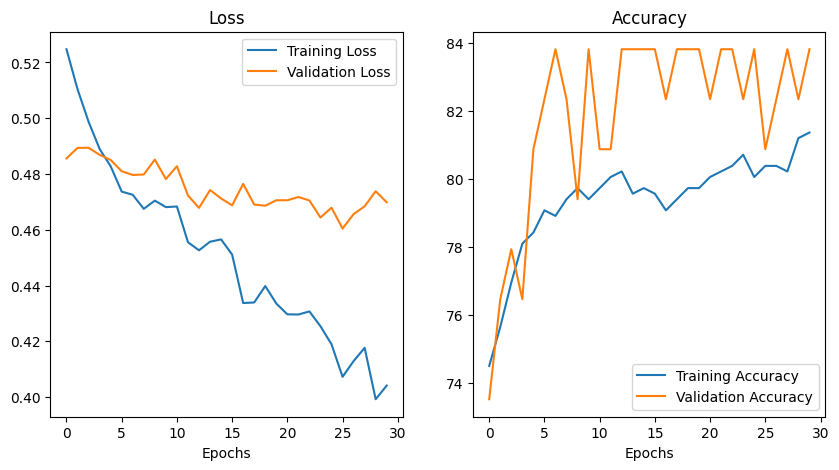

In [38]:
# fine-tune model

# initialize model
concrete_cnn = ConcreteCNN(
    n_bits=4,
    epochs=30,
    learning_rate=0.001,
    weight_decay=0.01
)
# train model
concrete_cnn = concrete_cnn.train(
        x_train=xtrain_breast,
        y_train=ytrain_breast,
        x_val=xval_breast,
        y_val=yval_breast,
        plot=True
)

100%|██████████| 100/100 [1:08:17<00:00, 40.97s/it]


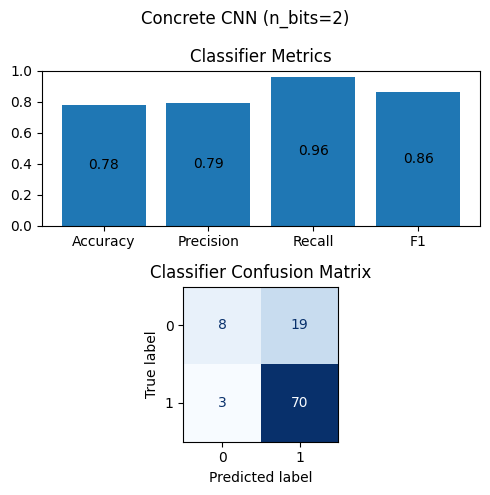

100%|██████████| 100/100 [1:48:43<00:00, 65.23s/it]


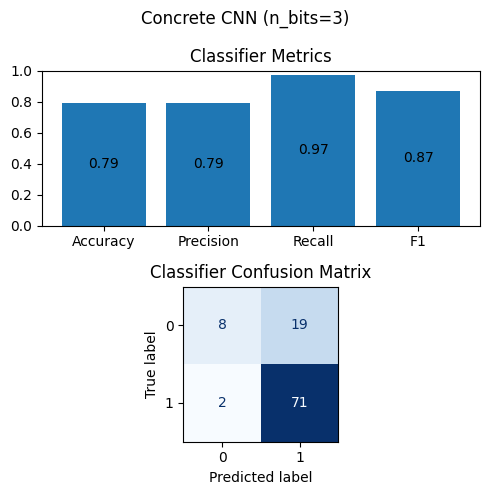

100%|██████████| 100/100 [1:22:34<00:00, 49.55s/it]


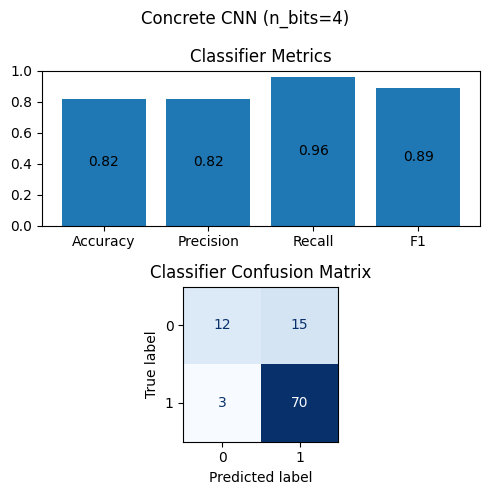

100%|██████████| 100/100 [3:42:01<00:00, 133.22s/it] 


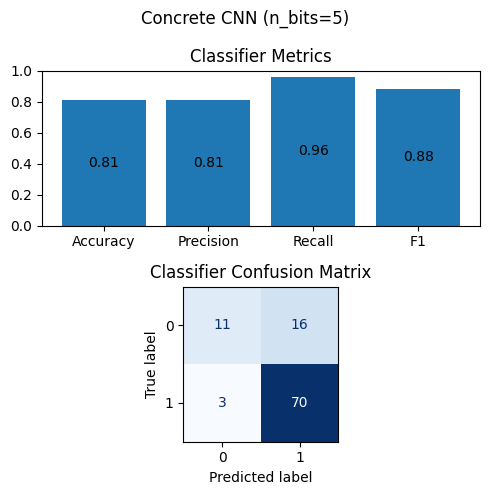

100%|██████████| 100/100 [2:38:16<00:00, 94.96s/it] 


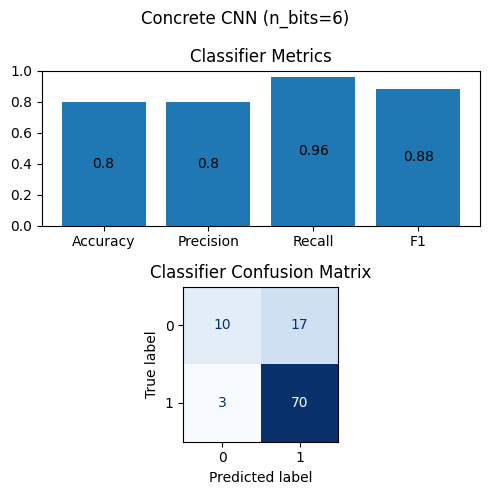

In [39]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_cnn = ConcreteCNN(
        n_bits=n_bits,
        epochs=30,
        learning_rate=0.001,
        weight_decay=0.01
    )
    # train model
    concrete_cnn = concrete_cnn.train(
        x_train=xtrain_breast,
        y_train=ytrain_breast,
        x_val=xval_breast,
        y_val=yval_breast,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_cnn.evaluate(xtest_breast, ytest_breast, fhe=fhe_mode)
    # append results
    results.append(concrete_cnn.log)

In [40]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,72.210706,0.932770,25.335193,4097.363233,40.973632,0.78,0.786517,0.958904,0.864198
1,3,83.483865,1.940854,29.027735,6523.064037,65.230640,0.79,0.788889,0.972603,0.871166
2,4,102.945236,2.029553,30.415921,4954.922402,49.549224,0.82,0.823529,0.958904,0.886076
3,5,134.748770,2.577749,29.148270,13321.958098,133.219581,0.81,0.813953,0.958904,0.880503
4,6,124.296214,2.243177,85.264877,9496.288093,94.962881,0.80,0.804598,0.958904,0.875000


#### OrganCMNIST

100%|██████████| 30/30 [46:47<00:00, 93.58s/it]


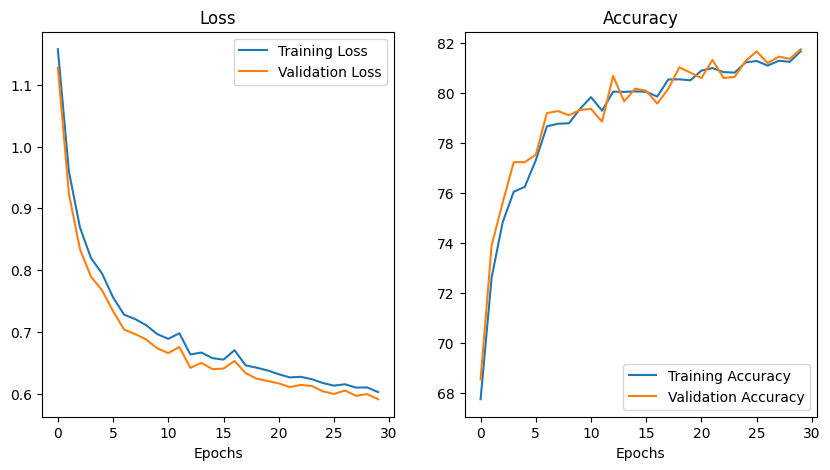

In [41]:
# fine-tune model

# initialize model
concrete_cnn = ConcreteCNN(
    n_bits=4,
    epochs=30,
    learning_rate=0.0001,
    weight_decay=0.001
)
# train model
concrete_cnn = concrete_cnn.train(
        x_train=xtrain_organ,
        y_train=ytrain_organ,
        x_val=xval_organ,
        y_val=yval_organ,
        plot=True
)

100%|██████████| 100/100 [2:04:54<00:00, 74.95s/it] 


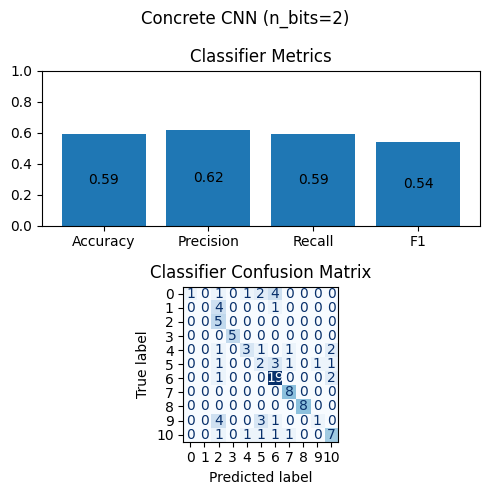

100%|██████████| 100/100 [1:43:06<00:00, 61.87s/it]


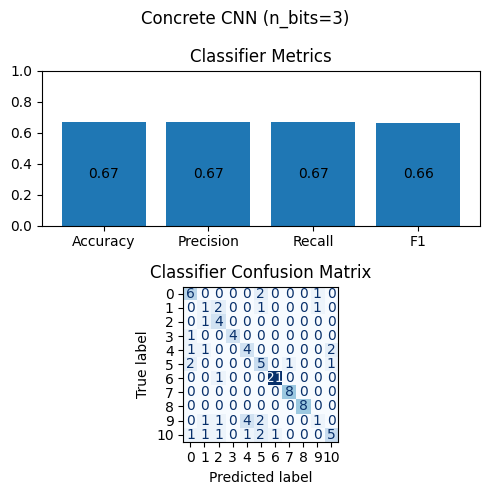

100%|██████████| 100/100 [2:36:41<00:00, 94.02s/it] 


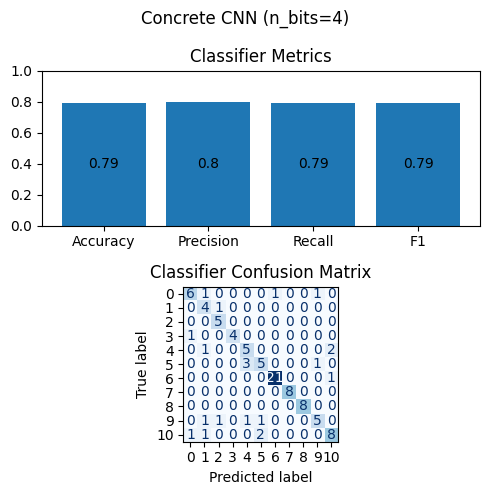

100%|██████████| 100/100 [3:35:31<00:00, 129.32s/it] 


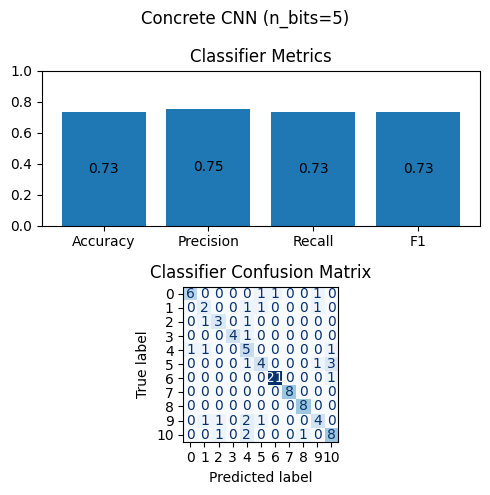

100%|██████████| 100/100 [4:04:45<00:00, 146.85s/it] 


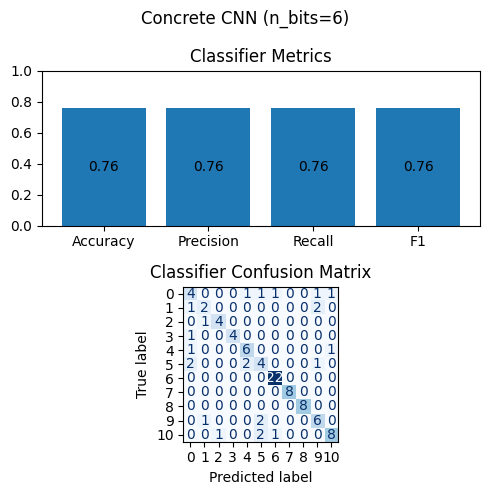

In [42]:
results = []

for n_bits in range(2,7):
    # initialize model
    concrete_cnn = ConcreteCNN(
        n_bits=n_bits,
        epochs=30,
        learning_rate=0.0001,
        weight_decay=0.001
    )
    # train model
    concrete_cnn = concrete_cnn.train(
        x_train=xtrain_organ,
        y_train=ytrain_organ,
        x_val=xval_organ,
        y_val=yval_organ,
        plot=False
    )
    # evaluate model
    ypred_concrete = concrete_cnn.evaluate(xtest_organ, ytest_organ, fhe=fhe_mode)
    # append results
    results.append(concrete_cnn.log)

In [43]:
# display results
results = pd.DataFrame(results)
results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,2984.749515,1.225280,99.326955,7494.744741,74.947447,0.59,0.596889,0.569674,0.515536
1,3,2799.469264,1.710370,29.858433,6186.857309,61.868573,0.67,0.622980,0.636777,0.615408
2,4,2817.141148,1.379998,28.578757,9401.617331,94.016173,0.79,0.776450,0.783999,0.772287
3,5,2908.266278,3.301567,27.404140,12931.971990,129.319720,0.73,0.713039,0.691070,0.695527
4,6,2820.660772,1.803700,70.240313,14685.196955,146.851970,0.76,0.742929,0.724747,0.731225
